In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# ------------------------------
# Attention Block
# ------------------------------
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        if g.shape[-1] != x.shape[-1] or g.shape[-2] != x.shape[-2]:
            g = F.interpolate(g, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)

        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi

# ------------------------------
# Attention UNet 128x128
# ------------------------------
class AttentionUNet128(nn.Module):
    def __init__(self):
        super(AttentionUNet128, self).__init__()

        # Encoder
        self.enc1 = self.conv_block(3, 64)      # 128x128
        self.enc2 = self.conv_block(64, 128)    # 64x64
        self.enc3 = self.conv_block(128, 256)   # 32x32
        self.pool = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)  # 16x16

        # Decoder with Attention
        self.att3 = AttentionBlock(256, 256, 128)  # Fixed here
        self.up3 = self.up_conv(512, 256)
        self.dec3 = self.conv_block(512, 256)      # 32x32

        self.att2 = AttentionBlock(128, 128, 64)
        self.up2 = self.up_conv(256, 128)
        self.dec2 = self.conv_block(256, 128)      # 64x64

        self.att1 = AttentionBlock(64, 64, 32)
        self.up1 = self.up_conv(128, 64)
        self.dec1 = self.conv_block(128, 64)       # 128x128

        self.final_out = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)              # 128x128
        e2 = self.enc2(self.pool(e1))  # 64x64
        e3 = self.enc3(self.pool(e2))  # 32x32

        b = self.bottleneck(self.pool(e3))  # 16x16

        d3 = self.up3(b)  # 32x32
        d3 = self.dec3(torch.cat([self.att3(d3, e3), d3], dim=1))

        d2 = self.up2(d3)  # 64x64
        d2 = self.dec2(torch.cat([self.att2(d2, e2), d2], dim=1))

        d1 = self.up1(d2)  # 128x128
        d1 = self.dec1(torch.cat([self.att1(d1, e1), d1], dim=1))

        out = self.final_out(d1)
        return self.sigmoid(out)

In [ ]:
from torch.utils.data import Dataset
import torch
import numpy as np

class ChunkedNPYDataset(Dataset):
    def __init__(self, chunk_dir):
        self.chunk_files = sorted([
            os.path.join(chunk_dir, f) for f in os.listdir(chunk_dir) if f.endswith(".npy")
        ])
        self.index_map = []
        self.chunk_lengths = []

        for i, file in enumerate(self.chunk_files):
            arr = np.load(file, mmap_mode='r')
            n = arr.shape[0]
            self.chunk_lengths.append(n)
            self.index_map.extend([(i, j) for j in range(n)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        file_idx, pair_idx = self.index_map[idx]
        arr = np.load(self.chunk_files[file_idx], mmap_mode='r')
        recon, orig = arr[pair_idx]
        # HWC → CHW for PyTorch
        recon = torch.tensor(recon.transpose(2, 0, 1), dtype=torch.float32)
        orig = torch.tensor(orig.transpose(2, 0, 1), dtype=torch.float32)
        return recon, orig


In [ ]:
from tqdm import tqdm
import os
import torch
from torch.utils.data import DataLoader

# === Paths
# ------------------------------
chunk_dir = "/content/drive/MyDrive/latent_exp_2025/chunked_dataset_pattern_40k"
save_dir = "/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionUNet128().to(device)

# === Load the checkpoint correctly ===
checkpoint_path = f"/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn/model_epoch10_step0126.pt"
print(f"Loading checkpoint from: {checkpoint_path}")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Dataloader
train_dataset = ChunkedNPYDataset(chunk_dir)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# ------------------------------
# Training Loop
# ------------------------------
#num_epochs = 10
epochs = 10
ckpt_interval = max(1, len(train_loader) // 10)  # 10 checkpoints per epoch

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    print(f"\nEpoch {epoch+1}/{epochs}")
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Batches")

    for batch_idx, (x, y) in pbar:
        try:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

            if (batch_idx + 1) % ckpt_interval == 0:
                ckpt_path = os.path.join(save_dir, f"model_epoch{epoch+11}_step{batch_idx+1:04d}.pt")
                torch.save(model.state_dict(), ckpt_path)

        except Exception as e:
            print(f"[ERROR] Batch {batch_idx+1}: {e}")
            continue

    # Compute average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.6f}")

    # Save the final model state at the end of each epoch
    final_ckpt_path = os.path.join(save_dir, f"model_epoch{epoch+11}_final.pt")
    torch.save(model.state_dict(), final_ckpt_path)

Loading checkpoint from: /content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn/model_epoch10_step0126.pt

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Batches: 100%|██████████| 2500/2500 [57:03<00:00,  1.37s/it, Loss=0.0043]


Epoch 1 | Avg Loss: 0.004221

Epoch 2/10


Batches: 100%|██████████| 2500/2500 [10:57<00:00,  3.80it/s, Loss=0.0051]


Epoch 2 | Avg Loss: 0.004104

Epoch 3/10


Batches: 100%|██████████| 2500/2500 [09:22<00:00,  4.44it/s, Loss=0.0033]


Epoch 3 | Avg Loss: 0.004011

Epoch 4/10


Batches: 100%|██████████| 2500/2500 [10:51<00:00,  3.84it/s, Loss=0.0044]


Epoch 4 | Avg Loss: 0.003925

Epoch 5/10


Batches: 100%|██████████| 2500/2500 [10:00<00:00,  4.16it/s, Loss=0.0035]


Epoch 5 | Avg Loss: 0.003852

Epoch 6/10


Batches: 100%|██████████| 2500/2500 [10:30<00:00,  3.97it/s, Loss=0.0022]


Epoch 6 | Avg Loss: 0.003790

Epoch 7/10


Batches: 100%|██████████| 2500/2500 [11:10<00:00,  3.73it/s, Loss=0.0046]


Epoch 7 | Avg Loss: 0.003733

Epoch 8/10


Batches: 100%|██████████| 2500/2500 [08:18<00:00,  5.02it/s, Loss=0.0048]


Epoch 8 | Avg Loss: 0.003677

Epoch 9/10


Batches: 100%|██████████| 2500/2500 [07:45<00:00,  5.37it/s, Loss=0.0033]


Epoch 9 | Avg Loss: 0.003615

Epoch 10/10


Batches: 100%|██████████| 2500/2500 [07:46<00:00,  5.36it/s, Loss=0.0042]


Epoch 10 | Avg Loss: 0.003556


3rd phase of training

In [ ]:
chunk_dir = "/content/drive/MyDrive/latent_exp_2025/chunked_dataset_pattern_40k"
save_dir = "/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AttentionUNet128().to(device)

# === Load the checkpoint correctly ===
checkpoint_path = f"/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn/model_epoch20_final.pt"
print(f"Loading checkpoint from: {checkpoint_path}")
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Dataloader
train_dataset = ChunkedNPYDataset(chunk_dir)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# ------------------------------
# Training Loop
# ------------------------------
#num_epochs = 10
epochs = 10
ckpt_interval = max(1, len(train_loader) // 5)  # 5 checkpoints per epoch

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0

    print(f"\nEpoch {epoch+1}/{epochs}")
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Batches")

    for batch_idx, (x, y) in pbar:
        try:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            pbar.set_postfix({"Loss": f"{loss.item():.4f}"})

            if (batch_idx + 1) % ckpt_interval == 0:
                ckpt_path = os.path.join(save_dir, f"model_epoch{epoch+21}_step{batch_idx+1:04d}.pt")
                torch.save(model.state_dict(), ckpt_path)

        except Exception as e:
            print(f"[ERROR] Batch {batch_idx+1}: {e}")
            continue

    # Compute average loss for the epoch
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Avg Loss: {avg_loss:.6f}")

    # Save the final model state at the end of each epoch
    final_ckpt_path = os.path.join(save_dir, f"model_epoch{epoch+21}_final.pt")
    torch.save(model.state_dict(), final_ckpt_path)

Loading checkpoint from: /content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn/model_epoch20_final.pt

Epoch 1/10


Batches: 100%|██████████| 2500/2500 [07:46<00:00,  5.36it/s, Loss=0.0036]

Epoch 1 | Avg Loss: 0.003494

Epoch 2/10



Batches: 100%|██████████| 2500/2500 [07:45<00:00,  5.37it/s, Loss=0.0041]


Epoch 2 | Avg Loss: 0.003437

Epoch 3/10


Batches: 100%|██████████| 2500/2500 [07:45<00:00,  5.37it/s, Loss=0.0037]


Epoch 3 | Avg Loss: 0.003384

Epoch 4/10


Batches: 100%|██████████| 2500/2500 [07:44<00:00,  5.38it/s, Loss=0.0046]


Epoch 4 | Avg Loss: 0.003329

Epoch 5/10


Batches: 100%|██████████| 2500/2500 [07:45<00:00,  5.37it/s, Loss=0.0044]


Epoch 5 | Avg Loss: 0.003280

Epoch 6/10


Batches: 100%|██████████| 2500/2500 [07:45<00:00,  5.37it/s, Loss=0.0047]


Epoch 6 | Avg Loss: 0.003236

Epoch 7/10


Batches: 100%|██████████| 2500/2500 [07:45<00:00,  5.37it/s, Loss=0.0025]


Epoch 7 | Avg Loss: 0.003193

Epoch 8/10


Batches: 100%|██████████| 2500/2500 [07:45<00:00,  5.37it/s, Loss=0.0033]


Epoch 8 | Avg Loss: 0.003151

Epoch 9/10


Batches: 100%|██████████| 2500/2500 [07:45<00:00,  5.37it/s, Loss=0.0026]


Epoch 9 | Avg Loss: 0.003116

Epoch 10/10


Batches: 100%|██████████| 2500/2500 [07:45<00:00,  5.37it/s, Loss=0.0042]


Epoch 10 | Avg Loss: 0.003081


TESTING

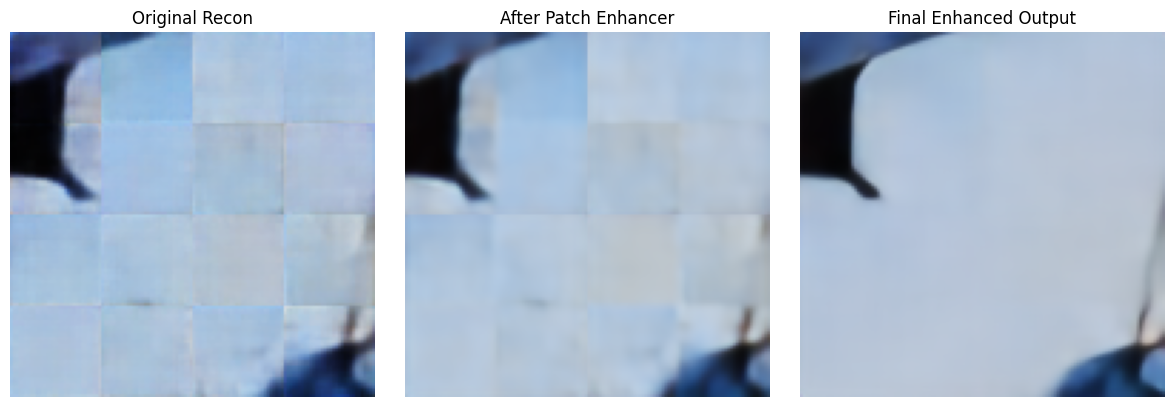

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

# === PatchEnhancer32_Residual ===
class PatchEnhancer32_Residual(nn.Module):
    def __init__(self):
        super().__init__()
        self.head = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.res_block1 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1)
        )
        self.res_block2 = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1)
        )
        self.tail = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x_head = self.head(x)
        res1 = self.res_block1(x_head) + x_head
        res2 = self.res_block2(res1) + res1
        return self.tail(res2)

# === AttentionUNet128 ===
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        if g.shape[-1] != x.shape[-1] or g.shape[-2] != x.shape[-2]:
            g = F.interpolate(g, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(torch.relu(g1 + x1))
        return x * psi

class AttentionUNet128(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = self.conv_block(256, 512)
        self.att3 = AttentionBlock(256, 256, 128)
        self.up3 = self.up_conv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.att2 = AttentionBlock(128, 128, 64)
        self.up2 = self.up_conv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.att1 = AttentionBlock(64, 64, 32)
        self.up1 = self.up_conv(128, 64)
        self.dec1 = self.conv_block(128, 64)
        self.final_out = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        b = self.bottleneck(self.pool(e3))
        d3 = self.up3(b)
        d3 = self.dec3(torch.cat([self.att3(d3, e3), d3], dim=1))
        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([self.att2(d2, e2), d2], dim=1))
        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([self.att1(d1, e1), d1], dim=1))
        return self.sigmoid(self.final_out(d1))

# === Load both models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model32 = PatchEnhancer32_Residual().to(device)
checkpoint32 = torch.load('/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_npy_32_residual/enhancer32_epoch_30.pt', map_location=device)
model32.load_state_dict(checkpoint32['model_state_dict'])
model32.eval()

model128 = AttentionUNet128().to(device)
model128.load_state_dict(torch.load('/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn/model_epoch30_final.pt', map_location=torch.device('cpu')))
model128.eval()

# === Load a sample 128x128 image (made from 4 patches)
chunk = np.load("/content/drive/MyDrive/latent_exp_2025/chunked_dataset_pattern_40k/dataset_chunk_00.npy")
recon, orig = chunk[915]  # (128, 128, 3)

# === Split into 4 × 32×32 patches
patches = []
for i in range(2):
    for j in range(2):
        patch = recon[i*64:(i+1)*64, j*64:(j+1)*64]
        patches.append(patch)

# === Enhance each patch
enhanced_patches = []
for p in patches:
    pt = torch.tensor(p.transpose(2, 0, 1)).unsqueeze(0).float().to(device)
    with torch.no_grad():
        ep = model32(pt).cpu().squeeze(0).permute(1, 2, 0).numpy()
        enhanced_patches.append(ep)

# === Stitch back to 128x128
top = np.concatenate(enhanced_patches[:2], axis=1)
bottom = np.concatenate(enhanced_patches[2:], axis=1)
stitched = np.concatenate([top, bottom], axis=0)

# === Enhance with AttentionUNet128
inp = torch.tensor(stitched.transpose(2, 0, 1)).unsqueeze(0).float().to(device)
with torch.no_grad():
    final = model128(inp).cpu().squeeze(0).permute(1, 2, 0).numpy()

# === Display
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(recon)
plt.title("Original Recon")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(stitched)
plt.title("After Patch Enhancer")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.clip(final, 0, 1))
plt.title("Final Enhanced Output")
plt.axis("off")
plt.tight_layout()
plt.show()


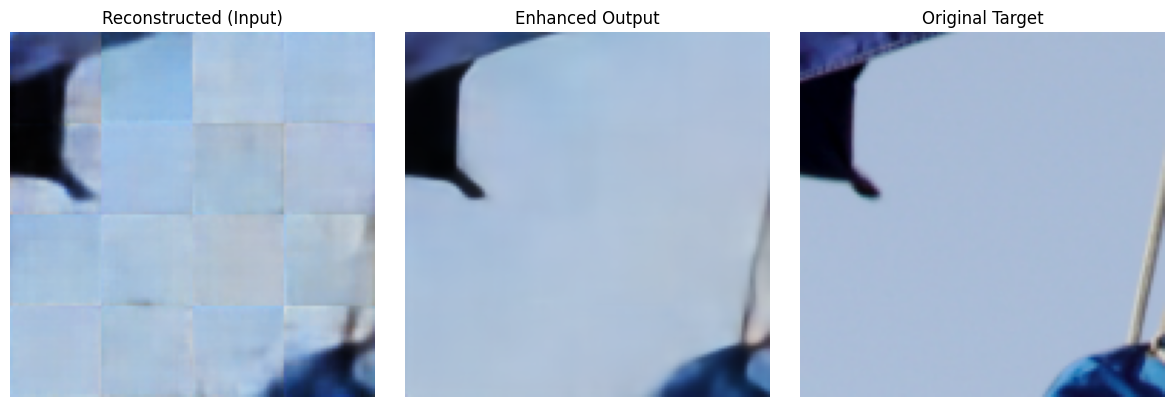

In [ ]:
chunk_dir = "/content/drive/MyDrive/latent_exp_2025/chunked_dataset_pattern_40k"
save_dir = "/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn"
os.makedirs(save_dir, exist_ok=True)

# === Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ChunkedNPYDataset(chunk_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)  # safer for Colab

#model = AttentionUNet128().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#criterion = nn.MSELoss()


# === Load trained model
model = AttentionUNet128().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn/model_epoch30_final.pt", map_location=torch.device('cpu')))
model.eval()

# === Load one .npy file and pick a sample
chunk_path = "/content/drive/MyDrive/latent_exp_2025/chunked_dataset_pattern_40k/dataset_chunk_00.npy"
data = np.load(chunk_path)
recon_np, orig_np = data[915]  # pick any index

# Convert to torch tensors and move to GPU if available
recon_tensor = torch.tensor(recon_np.transpose(2, 0, 1)).unsqueeze(0).float().to(device)  # (1, 3, 128, 128)

# === Forward pass
with torch.no_grad():
    enhanced_tensor = model(recon_tensor).cpu().squeeze(0).permute(1, 2, 0).numpy()

# Clip values to [0,1]
enhanced_tensor = np.clip(enhanced_tensor, 0, 1)

# === Plot the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(recon_np)
plt.title("Reconstructed (Input)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(enhanced_tensor)
plt.title("Enhanced Output")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(orig_np)
plt.title("Original Target")
plt.axis("off")

plt.tight_layout()
plt.show()


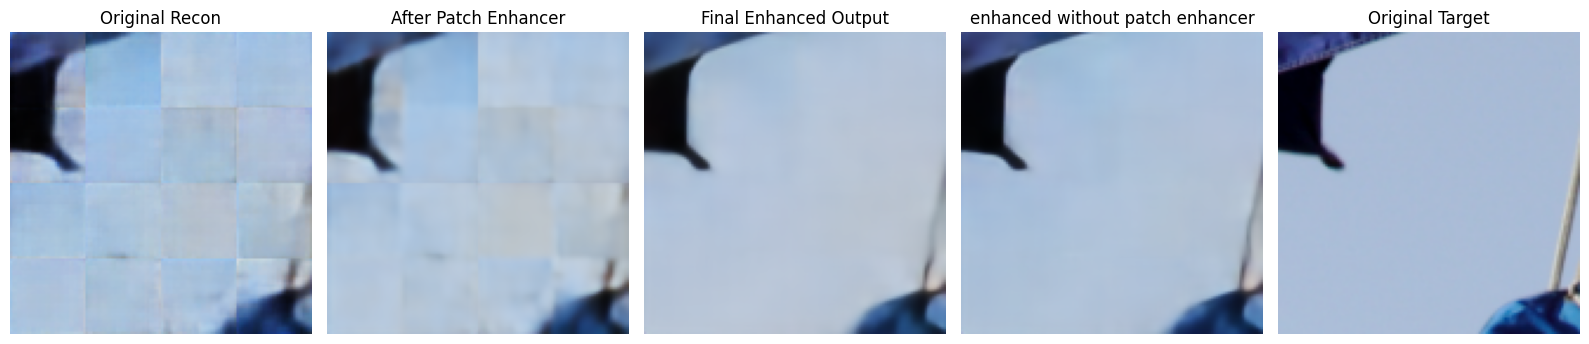

In [ ]:
plt.figure(figsize=(16, 4))

# 1️⃣ Original Reconstructed (Input)
plt.subplot(1, 5, 1)
plt.imshow(recon)
plt.title("Original Recon")
plt.axis("off")

# 2️⃣ Stitched Image after Patch Enhancer
plt.subplot(1, 5, 2)
plt.imshow(stitched)
plt.title("After Patch Enhancer")
plt.axis("off")

# 3️⃣ Final Enhanced Output after Attention UNet
plt.subplot(1, 5, 3)
plt.imshow(np.clip(final, 0, 1))
plt.title("Final Enhanced Output")
plt.axis("off")

plt.subplot(1, 5, 4)
plt.imshow(enhanced_tensor)
plt.title("enhanced without patch enhancer")
plt.axis("off")

# 4️⃣ Original Target Image
plt.subplot(1, 5, 5)
plt.imshow(orig)
plt.title("Original Target")
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import cv2

# === Calculate PSNR (Peak Signal-to-Noise Ratio)
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    pixel_max = 1.0  # Since images are in [0, 1] range
    psnr = 20 * np.log10(pixel_max / np.sqrt(mse))
    return psnr

# === Compute PSNR between enhanced output and original target
psnr_value = calculate_psnr(enhanced_tensor, orig_np)
psnr_value


np.float32(30.638748)

In [ ]:
psnr_value = calculate_psnr(final, orig_np)
psnr_value

np.float32(24.3896)

zoom potions and apply the unet maybe

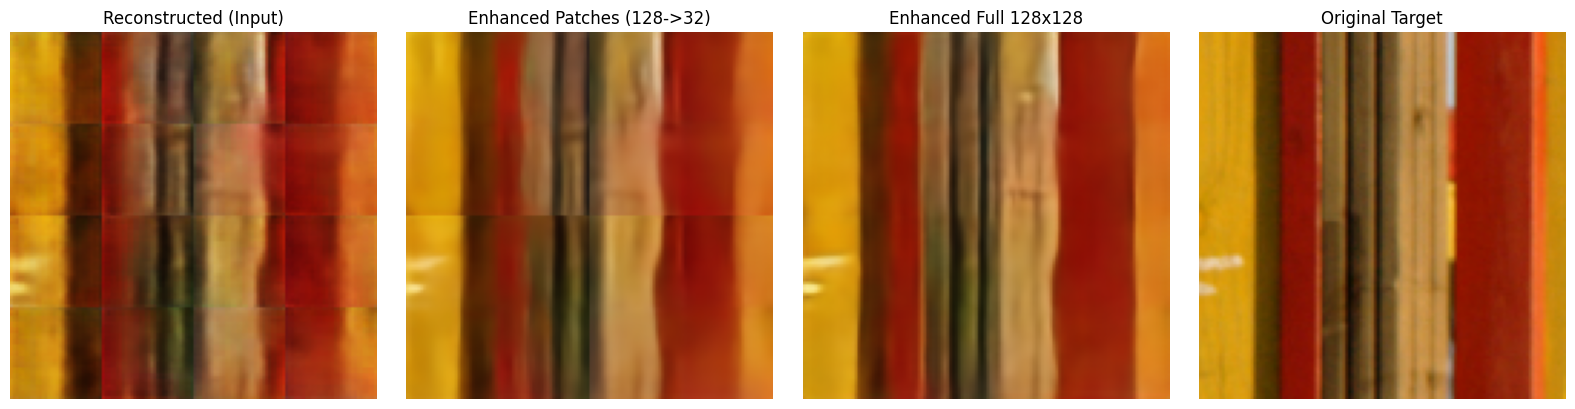

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.functional import interpolate

# === Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load the model
model = AttentionUNet128().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn/model_epoch30_final.pt", map_location=device))
model.eval()

# === Load one .npy file and pick a sample
chunk_path = "/content/drive/MyDrive/latent_exp_2025/chunked_dataset_pattern_40k/dataset_chunk_00.npy"
data = np.load(chunk_path)
recon_np, orig_np = data[655]  # pick any index

# === Split into 4 × 32×32 patches
patches = []
for i in range(2):
    for j in range(2):
        patch = recon_np[i*64:(i+1)*64, j*64:(j+1)*64]
        patches.append(patch)

# === Process each 32x32 patch:
enhanced_patches = []
for p in patches:
    # 1️⃣ Resize to 128x128
    p_tensor = torch.tensor(p.transpose(2, 0, 1)).unsqueeze(0).float().to(device)
    p_resized = interpolate(p_tensor, size=(128, 128), mode='bilinear')

    # 2️⃣ Enhance with AttentionUNet128
    with torch.no_grad():
        p_enhanced = model(p_resized)

    # 3️⃣ Downsample back to 32x32
    p_downsampled = interpolate(p_enhanced, size=(64, 64), mode='bilinear')
    p_downsampled = p_downsampled.cpu().squeeze(0).permute(1, 2, 0).numpy()
    enhanced_patches.append(p_downsampled)

# === Stitch back to 128x128
top = np.concatenate(enhanced_patches[:2], axis=1)
bottom = np.concatenate(enhanced_patches[2:], axis=1)
stitched = np.concatenate([top, bottom], axis=0)

# === Clip values to [0,1]
stitched = np.clip(stitched, 0, 1)

# === Display
plt.figure(figsize=(16, 4))

# 1️⃣ Original Reconstructed (Input)
plt.subplot(1, 4, 1)
plt.imshow(recon_np)
plt.title("Reconstructed (Input)")
plt.axis("off")

# 2️⃣ Stitched Image after UNet128 per Patch
plt.subplot(1, 4, 2)
plt.imshow(stitched)
plt.title("Enhanced Patches (128->32)")
plt.axis("off")

# 3️⃣ Enhanced Output with full 128x128
plt.subplot(1, 4, 3)
plt.imshow(enhanced_tensor)
plt.title("Enhanced Full 128x128")
plt.axis("off")

# 4️⃣ Original Target
plt.subplot(1, 4, 4)
plt.imshow(orig_np)
plt.title("Original Target")
plt.axis("off")

plt.tight_layout()
plt.show()


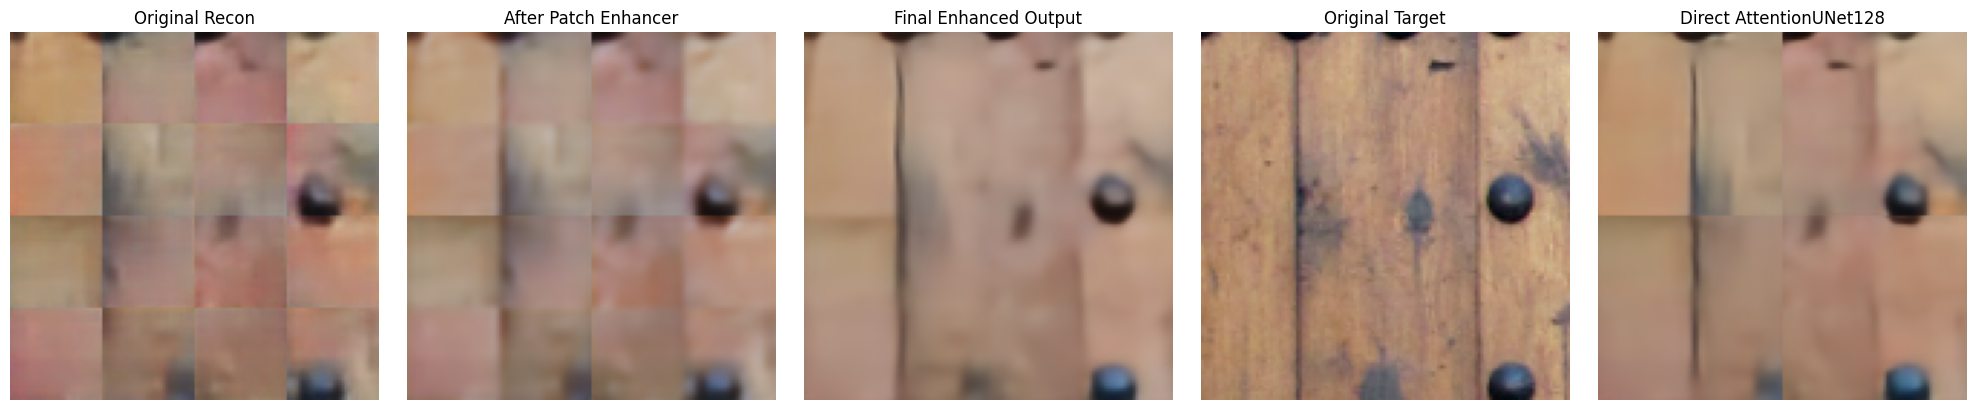

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# === Enhance each 32x32 patch directly with AttentionUNet128 (without PatchEnhancer32_Residual)
direct_enhanced_patches = []
for p in patches:
    pt = torch.tensor(p.transpose(2, 0, 1)).unsqueeze(0).float().to(device)
    with torch.no_grad():
        ep = model128(pt).cpu().squeeze(0).permute(1, 2, 0).numpy()
        direct_enhanced_patches.append(ep)

# === Stitch back to 128x128 (direct UNet only, no patch enhancement)
top_direct = np.concatenate(direct_enhanced_patches[:2], axis=1)
bottom_direct = np.concatenate(direct_enhanced_patches[2:], axis=1)
stitched_direct = np.concatenate([top_direct, bottom_direct], axis=0)

# === Display
plt.figure(figsize=(20, 4))

# 1️⃣ Original Reconstructed (Input)
plt.subplot(1, 5, 1)
plt.imshow(recon)
plt.title("Original Recon")
plt.axis("off")

# 2️⃣ Stitched Image after Patch Enhancer
plt.subplot(1, 5, 2)
plt.imshow(stitched)
plt.title("After Patch Enhancer")
plt.axis("off")

# 3️⃣ Final Enhanced Output after Attention UNet
plt.subplot(1, 5, 3)
plt.imshow(np.clip(final, 0, 1))
plt.title("Final Enhanced Output")
plt.axis("off")

# 4️⃣ Original Target Image
plt.subplot(1, 5, 4)
plt.imshow(orig)
plt.title("Original Target")
plt.axis("off")

# 5️⃣ Direct AttentionUNet128 Enhancement (no PatchEnhancer)
plt.subplot(1, 5, 5)
plt.imshow(stitched_direct)
plt.title("Direct AttentionUNet128")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
chunk_dir = "/content/drive/MyDrive/latent_exp_2025/chunked_dataset_pattern_40k"
save_dir = "/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn"
os.makedirs(save_dir, exist_ok=True)

# === Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ChunkedNPYDataset(chunk_dir)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)  # safer for Colab

#model = AttentionUNet128().to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#criterion = nn.MSELoss()


# === Load trained model
model = AttentionUNet128().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/latent_exp_2025/enhance_ckpts_png_128_attn/model_epoch10_step0126.pt", map_location=torch.device('cpu')))
model.eval()

# === Load one .npy file and pick a sample
chunk_path = "/content/drive/MyDrive/latent_exp_2025/chunked_dataset_pattern_40k/dataset_chunk_00.npy"
data = np.load(chunk_path)
recon_np, orig_np = data[135]  # pick any index

# Convert to torch tensors and move to GPU if available
recon_tensor = torch.tensor(recon_np.transpose(2, 0, 1)).unsqueeze(0).float().to(device)  # (1, 3, 128, 128)

# === Forward pass
with torch.no_grad():
    enhanced_tensor = model(recon_tensor).cpu().squeeze(0).permute(1, 2, 0).numpy()

# Clip values to [0,1]
enhanced_tensor = np.clip(enhanced_tensor, 0, 1)

# === Plot the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(recon_np)
plt.title("Reconstructed (Input)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(enhanced_tensor)
plt.title("Enhanced Output")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(orig_np)
plt.title("Original Target")
plt.axis("off")

plt.tight_layout()
plt.show()